# **CNN for Human Activity Recognition with MHEALTH dataset**

Importing all necessary libraries

In [0]:
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib import image
from matplotlib import pyplot

import numpy as np 
import pandas as pd
from time import time

from scipy import stats
from sklearn import metrics
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils

import torch.optim as optim
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout2d
from torch.optim import Adam, SGD
from sklearn.metrics import f1_score, precision_score, recall_score

# **Data preparation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Loading all files and creating train, validation and test sets (60/20/20)

In [3]:
sensors_data1 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject1.csv')
sensors_data2 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject2.csv')
sensors_data3 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject3.csv')
sensors_data4 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject4.csv')
sensors_data5 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject5.csv')
sensors_data6 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject6.csv')
sensors_data7 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject7.csv')
sensors_data8 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject8.csv')
sensors_data9 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject9.csv')
sensors_data10 = pd.read_csv('drive/My Drive/ML final project/mHealth_subject10.csv')

x_train = pd.concat([sensors_data1, sensors_data2, sensors_data3, sensors_data4, sensors_data5, sensors_data6])
y_train = x_train.Label
x_val = pd.concat([sensors_data7, sensors_data8])
y_val = x_val.Label
x_test = pd.concat([sensors_data9, sensors_data10])
y_test = x_test.Label



print("x_train shape = ", x_train.shape)
print("y_train shape =",y_train.shape)

print("x_val shape =" ,x_val.shape)
print("y_val shape =",y_val.shape)

print("x_test shape =" ,x_test.shape)
print("y_test shape =",y_test.shape)


x_train shape =  (748801, 25)
y_train shape = (748801,)
x_val shape = (233472, 25)
y_val shape = (233472,)
x_test shape = (233472, 25)
y_test shape = (233472,)


In [0]:
x_test

,Unnamed: 0,acChestX,acChestY,acChestZ,ecgLead1,ecgLead2,acLAnkleX,acLAnkleY,acLAnkleZ,gyrLAnkleX,gyrLAnkleY,gyrLAnkleZ,mLAnkleX,mLAnkleY,mLAnkleZ,acRightLowerArmX,acRightLowerArmY,acRightLowerArmZ,gyrRightLowerArmX,gyrRightLowerArmY,gyrRightLowerArmZ,mRightLowerArmX,mRightLowerArmY,mRightLowerArmZ,Label
0,0,-9.5767,-1.466100,-0.34247,-0.087912,0.037677,0.37048,-10.0150,0.50297,0.51206,-0.81426,-0.46365,0.37877,0.730160,-0.59208,-3.7504,-8.9035,0.64857,0.313730,-1.08830,0.32759,0.54755,0.89477,-0.72002,0
1,1,-9.5928,-1.170000,-0.67372,-0.108840,0.016745,0.37621,-9.8393,0.23055,0.51206,-0.81426,-0.46365,0.20671,0.364910,-0.87358,-3.7264,-8.8417,0.82875,0.313730,-1.08830,0.32759,0.54758,0.89837,-0.35904,0
2,2,-9.8840,-1.255500,-0.49195,-0.100470,0.037677,0.35848,-9.7266,0.61101,0.51206,-0.81426,-0.46365,0.55505,0.728390,-0.45129,-3.7811,-8.9232,0.67884,0.313730,-1.08830,0.32759,0.54577,0.71692,-0.35726,0
3,3,-9.5893,-1.345500,-0.28952,0.071167,0.163270,0.36937,-9.8759,0.53073,0.51206,-0.81426,-0.46365,0.38299,0.363140,-0.73279,-3.8521,-8.9727,0.72845,0.315690,-1.08420,0.32328,0.54577,0.71692,-0.35726,0
4,4,-9.8028,-1.274400,-0.54627,1.063300,0.502350,0.33570,-9.8390,0.26141,0.49722,-0.81614,-0.46365,0.20244,0.548430,-0.73103,-3.7814,-9.0327,0.72545,0.315690,-1.08420,0.32328,0.54395,0.53547,-0.35549,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98299,98299,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.78490,-9.8287,0.29725,-0.34137,-0.90056,-0.61493,-0.68764,0.557340,-1.14620,-3.7198,-8.9071,0.29423,0.041176,-0.99384,-0.48060,2.40890,7.49610,7.91550,0
98300,98300,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.86870,-9.8766,0.46236,-0.34137,-0.90056,-0.61493,-0.86819,0.742630,-1.14450,-3.7160,-8.7455,0.44814,0.041176,-0.99384,-0.48060,1.69450,7.86600,7.89750,0
98301,98301,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.69280,-9.9290,0.16631,-0.34137,-0.90056,-0.61493,-0.86841,0.008684,-1.13710,-3.8824,-9.1155,0.45048,0.041176,-0.99384,-0.48060,1.15770,8.05280,7.88490,0
98302,98302,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.52790,-9.6306,0.30458,-0.34137,-0.90056,-0.61493,-0.33979,-0.730550,-0.70740,-3.5564,-9.1441,0.59488,0.041176,-0.99384,-0.48060,0.27441,9.48790,5.32580,0


Dropping first column with iterations number, column with the label and colums for ECG leads data.

In [4]:
x_train.drop(x_train.columns[[0, 4, 5, 24]], axis=1, inplace= True)
x_val.drop(x_val.columns[[0, 4, 5, 24]], axis=1, inplace= True)
x_test.drop(x_test.columns[[0, 4, 5, 24]], axis=1, inplace= True)


print("x_train shape = ", x_train.shape)
print("y_train shape =",y_train.shape)

print("x_test shape =" ,x_val.shape)
print("y_test shape =",y_val.shape)

print("x_test shape =" ,x_test.shape)
print("y_test shape =",y_test.shape)



x_train shape =  (748801, 21)
y_train shape = (748801,)
x_test shape = (233472, 21)
y_test shape = (233472,)
x_test shape = (233472, 21)
y_test shape = (233472,)


Data segmentation: splitting data along the temporal axis.

Window size = 50 with step = 25 (%50 of window size).

Label for each window is the labek of the most frequent activity in the given time period.

In [6]:
def windowz(data, size, step):
    start = 0
    while start < len(data):
        yield start, start + size
        start += step

def segment_opp(inputs, targets, window_size, step):
    segments = np.zeros(((len(inputs) - window_size) // step + 1, window_size, 21))
    labels = np.zeros(((len(targets) - window_size) // step + 1))
    i_segment = 0
    i_label = 0
    for (start, end) in windowz(inputs, window_size, step):
        if(len(inputs[start:end]) == window_size):
            m = stats.mode(y_train[start:end])
            segments[i_segment] = x_train[start:end]
            labels[i_label] = m[0]
            i_label+=1
            i_segment+=1
    return segments, labels


window_size = 50
step = 25
print("segmenting signal...")
train_x, train_y = segment_opp(x_train, y_train, window_size, step)
val_x, val_y = segment_opp(x_val, y_val, window_size, step)
test_x, test_y = segment_opp(x_test, y_test, window_size, step)
print("signal segmented.")
print("Shape of segmented train inputs: {}".format(train_x.shape))
print("Shape of segmented train labels: {}".format(train_y.shape))

print("Shape of segmented test inputs:  {}".format(val_x.shape))
print("Shape of segmented test labels:  {}".format(val_y.shape))

print("Shape of segmented test inputs:  {}".format(test_x.shape))
print("Shape of segmented test labels:  {}".format(test_y.shape))

segmenting signal...
signal segmented.
Shape of segmented train inputs: (29951, 50, 21)
Shape of segmented train labels: (29951,)
Shape of segmented test inputs:  (9337, 50, 21)
Shape of segmented test labels:  (9337,)
Shape of segmented test inputs:  (9337, 50, 21)
Shape of segmented test labels:  (9337,)


In [0]:
x_val

,acChestX,acChestY,acChestZ,acLAnkleX,acLAnkleY,acLAnkleZ,gyrLAnkleX,gyrLAnkleY,gyrLAnkleZ,mLAnkleX,mLAnkleY,mLAnkleZ,acRightLowerArmX,acRightLowerArmY,acRightLowerArmZ,gyrRightLowerArmX,gyrRightLowerArmY,gyrRightLowerArmZ,mRightLowerArmX,mRightLowerArmY,mRightLowerArmZ
0,-9.5409,-1.23920,-0.77468,2.3448,-9.6597,1.353000,0.781080,-0.52158,-0.049116,0.026045,0.18323,-0.86815,-7.0806,-6.6875,2.2490,-0.64902,-0.13758,0.82328,-1.6286,-1.2796,-2.5469
1,-9.5641,-1.59150,-0.92218,2.0888,-9.4906,1.431800,0.779220,-0.52533,-0.039293,0.378720,0.54667,-0.59024,-6.8389,-6.5352,2.4753,-0.64902,-0.13758,0.82328,-1.2749,-1.8203,-1.8124
2,-9.5849,-1.56120,-0.94051,2.1386,-9.4919,1.307200,0.779220,-0.52533,-0.039293,0.555000,0.54491,-0.44945,-6.6737,-6.6865,2.3532,-0.64902,-0.13758,0.82328,-1.4563,-1.9999,-1.8142
3,-9.7097,-1.38230,-0.77703,2.2127,-9.6292,1.436500,0.779220,-0.52533,-0.039293,0.555050,0.72839,-0.45129,-6.7865,-6.4962,2.3835,-0.63922,-0.14579,0.83621,-1.4509,-1.4592,-2.1805
4,-9.7578,-1.50300,-0.87211,2.2195,-9.6426,1.081700,0.779220,-0.52533,-0.039293,0.382990,0.36314,-0.73279,-6.6627,-6.4775,2.2490,-0.63922,-0.14579,0.83621,-1.0881,-1.0890,-1.0939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129019,-5.8140,-0.21063,1.10740,2.4278,-9.5092,-1.419900,-0.087199,-0.61351,-0.913560,-31.373000,-36.56700,-1.17140,-6.5514,5.1998,-2.0213,-0.68431,-0.10678,-0.73276,19.3450,13.5280,29.1320
129020,-5.4361,-0.41584,0.79415,2.8406,-9.4646,-0.913570,-0.087199,-0.61351,-0.913560,-42.463000,-34.80500,1.48590,-6.6629,5.5525,-2.7536,-0.68431,-0.10678,-0.73276,13.8190,17.4000,29.7050
129021,-5.4011,-0.14952,0.46023,3.4740,-10.7230,-0.053508,-0.087199,-0.61351,-0.913560,-57.010000,-27.32000,5.02090,-7.3405,6.0766,-2.3420,-0.68431,-0.10678,-0.73276,3.4286,19.7010,31.6410
129022,-5.6132,-0.14576,0.88162,2.1789,-11.5930,-0.849510,-0.087199,-0.61351,-0.913560,-71.421000,-11.57900,10.05800,-8.1415,6.5154,-2.4555,-0.66667,-0.11499,-0.75862,-3.4091,18.1530,33.3240


Reshaping data to fit to the convolutional model and converting to the tensor forms. Afterwards all train, validation and test datasets are loaded to the dataloaders.

In [0]:
num_features = 21
train_x = train_x.reshape(len(train_x), 1, window_size, num_features) 
val_x = val_x.reshape(len(val_x), 1, window_size, num_features)
test_x = test_x.reshape(len(test_x), 1, window_size, num_features)

train_y0 = np.array(train_y)
val_y0 = np.array(val_y)
test_y0 = np.array(test_y)

train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()

val_x = torch.from_numpy(val_x).float()
val_y = torch.from_numpy(val_y).long()

test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

training_data = data_utils.TensorDataset(train_x, train_y)
valid_data = data_utils.TensorDataset(val_x, val_y)
testing_data = data_utils.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=400, 
                                              shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=400, 
                                                shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size=400, 
                                                shuffle=False)

dataloaders = [train_loader, val_loader, test_loader]

In [0]:
print(val_x.shape)

torch.Size([2144, 1, 125, 21])


Introducing weights to handle imbalances in data.

In [0]:
from sklearn.utils import class_weight
class_weights0 = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y0),
                                                 train_y0)
from sklearn.utils import class_weight
class_weights1= class_weight.compute_class_weight('balanced',
                                                 np.unique(val_y0),
                                                 val_y0)
from sklearn.utils import class_weight
class_weights2= class_weight.compute_class_weight('balanced',
                                                 np.unique(test_y0),
                                                 test_y0)

In [0]:
class_weights0

array([0.10640694, 3.12184699, 3.13458922, 3.13033027, 3.12184699,
       3.12184699, 3.24496208, 3.19545503, 3.18221419, 3.13033027,
       3.12184699, 3.12184699, 9.32762379])

In [0]:
class_weights2

array([ 0.0985893 ,  2.90737834,  2.93735131,  2.90737834,  2.90737834,
        2.90737834,  4.74871795,  5.93589744,  5.37590711,  5.81475667,
        5.81475667,  5.81475667, 16.760181  ])

# **Model**

Building our CNN model architecrture

In [0]:
def compute_conv_dim(dim_size, kernel_size, padding, stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)


class Conv2Net(nn.Module):
    def __init__(self, num_filters_1, num_filters_2, num_filters_3,
                 kernel_size_1, kernel_size_2, kernel_size_3, num_l1):
        
        super(Conv2Net, self).__init__()        
        num_classes = 13
        channels = train_x.shape[1]
        height = train_x.shape[2]
        width = train_x.shape[3]
        stride = 1
        padding = 0
        max_pool_size = 2
        max_pool_stride = 2

        self.max_pool = MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride)
        self.conv_1 = Conv2d(in_channels=channels, out_channels=num_filters_1, kernel_size=(kernel_size_1, 1), stride=stride,
                            padding=padding)       
        self.conv_out_height = compute_conv_dim(height, kernel_size_1, padding, stride)//max_pool_size
        self.conv_out_width = compute_conv_dim(width, 1, padding, stride)//max_pool_size
        self.bn1 = nn.BatchNorm2d(num_features=num_filters_1)

        self.conv_2 = Conv2d(in_channels=num_filters_1, out_channels=num_filters_2, kernel_size=(kernel_size_2, 1), stride=stride, padding=padding)
        self.conv_out_height = compute_conv_dim(self.conv_out_height, kernel_size_2, padding, stride)//max_pool_size
        self.conv_out_width = compute_conv_dim(self.conv_out_width, 1, padding, stride)// max_pool_size
        self.bn2 = nn.BatchNorm2d(num_features=num_filters_2)
       
        self.l1_in_features = num_filters_2 * self.conv_out_height * self.conv_out_width
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1)
        
        self.bn4 = nn.BatchNorm1d(num_features=num_l1)

        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes)
        
        self.dropout = Dropout2d(p=0.5)

    def forward(self, x): 
       
        x = x.cuda()
        x = F.relu(self.bn1(self.conv_1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv_2(x)))
        x = self.max_pool(x)
         
        x = x.view(-1, self.l1_in_features)
        
        x = F.relu(self.bn4(self.l_1(x)))        
        x = self.dropout(x)

        return F.log_softmax(self.l_out(x), dim=1)

EarlyStopping class to stop the training before it overfits

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #torch.save(model.state_dict(), 'checkpoint.pt')
        torch.save(model, 'drive/My Drive/ML final project/checkpoint50finalf.pt')
        self.val_loss_min = val_loss

# **Training and testing the model**

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.float()
        target = target.long()
        data = data.to(device)
        target = target.to(device)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        weights = class_weights0
        class_weights = torch.FloatTensor(weights).cuda()
        loss = F.cross_entropy(output, target, weight=class_weights)
        # loss = F.nll_loss(output, target, weight=class_weights)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    return losses

In [0]:
def test(model, device, data_loader):
    model.eval()
    test_loss = 0
    f1=0
    precision = 0
    recall = 0
    correct = 0
    i=0
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            i += 1
            weights = class_weights1
            class_weights = torch.FloatTensor(weights).cuda()
            
            # test_loss += F.nll_loss(output, target.to(device), weight=class_weights, reduction='sum').item() # sum up batch loss
            test_loss += F.cross_entropy(output, target.to(device), weight=class_weights, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            pred = pred.cpu()
            correct += pred.eq(target.view_as(pred)).sum().item()
            f1 += f1_score(pred, target, average='macro')
            precision += precision_score(pred, target, average='macro')
            recall += recall_score(pred, target, average='macro')
    test_loss /= len(data_loader.dataset)
    f1 = f1 / i
    precision = precision/i
    recall = recall/i
    print('\nTest set: Average loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 score: {:.4f},   Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, precision, recall, f1, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return test_loss

In [14]:
use_cuda = torch.cuda.is_available()
device=torch.device('cuda:0')
model = Conv2Net(256, 128, 128, 6, 6, 4, 128).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.00001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epoch = 200
train_losses = []
val_losses = []
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=20, verbose=True)
t0=time()
for i in range(epoch):
    train_loss = train(model, device, train_loader, optimizer, i)
    train_losses.extend(train_loss)
    val_loss = test(model, device, val_loader)
    val_losses.append(val_loss)
    # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
    # load the last checkpoint with the best model
    last_model = torch.load('drive/My Drive/ML final project/checkpoint50finalf.pt')
    # model.load_state_dict(torch.load('checkpoint.pt'))
print ("training time:", round(time()-t0, 3), "s")


Train Epoch: 0 [0/29951 (0%)]	Loss: 2.670990
Train Epoch: 0 [20000/29951 (67%)]	Loss: 1.125937


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test set: Average loss: 0.8935, Precision: 0.0935, Recall: 0.1478, F1 score: 0.0746,   Accuracy: 2093/9337 (22%)

Validation loss decreased (inf --> 0.893537).  Saving model ...
Train Epoch: 1 [0/29951 (0%)]	Loss: 0.820277


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Conv2Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 1 [20000/29951 (67%)]	Loss: 0.575740

Test set: Average loss: 0.5187, Precision: 0.1275, Recall: 0.1904, F1 score: 0.1112,   Accuracy: 3114/9337 (33%)

Validation loss decreased (0.893537 --> 0.518700).  Saving model ...
Train Epoch: 2 [0/29951 (0%)]	Loss: 0.576933
Train Epoch: 2 [20000/29951 (67%)]	Loss: 0.446127

Test set: Average loss: 0.3451, Precision: 0.1493, Recall: 0.1959, F1 score: 0.1349,   Accuracy: 4207/9337 (45%)

Validation loss decreased (0.518700 --> 0.345080).  Saving model ...
Train Epoch: 3 [0/29951 (0%)]	Loss: 0.409020
Train Epoch: 3 [20000/29951 (67%)]	Loss: 0.340618

Test set: Average loss: 0.2615, Precision: 0.1811, Recall: 0.2079, F1 score: 0.1643,   Accuracy: 5163/9337 (55%)

Validation loss decreased (0.345080 --> 0.261485).  Saving model ...
Train Epoch: 4 [0/29951 (0%)]	Loss: 0.298368
Train Epoch: 4 [20000/29951 (67%)]	Loss: 0.404165

Test set: Average loss: 0.2374, Precision: 0.2019, Recall: 0.2184, F1 score: 0.1881,   Accuracy: 5857/9337 (63%)

In [0]:
print(epoch)
print(train_losses)
print(val_losses)

200
[2.641268491744995, 1.121956706047058, 0.8708373308181763, 0.5824713110923767, 0.5959499478340149, 0.4502660632133484, 0.4198485314846039, 0.2767498195171356, 0.3035792410373688, 0.3107570707798004, 0.25615787506103516, 0.3101062774658203, 0.1994459182024002, 0.23893865942955017, 0.21491293609142303, 0.2052297294139862, 0.18573959171772003, 0.2103005051612854, 0.19354230165481567, 0.2324867695569992, 0.1991918832063675, 0.167996346950531, 0.16560854017734528, 0.1912914663553238, 0.1823722869157791, 0.13787539303302765, 0.15155968070030212, 0.16393277049064636, 0.1123584732413292, 0.13945819437503815, 0.12391341477632523, 0.10491505265235901, 0.12978124618530273, 0.11956332623958588, 0.12778010964393616, 0.14542293548583984, 0.14704039692878723, 0.1342046707868576, 0.12072135508060455, 0.13611526787281036, 0.12990233302116394, 0.11038235574960709, 0.11787528544664383, 0.09914693236351013, 0.11674658209085464, 0.11836022883653641, 0.11923998594284058, 0.10510315001010895, 0.107859939

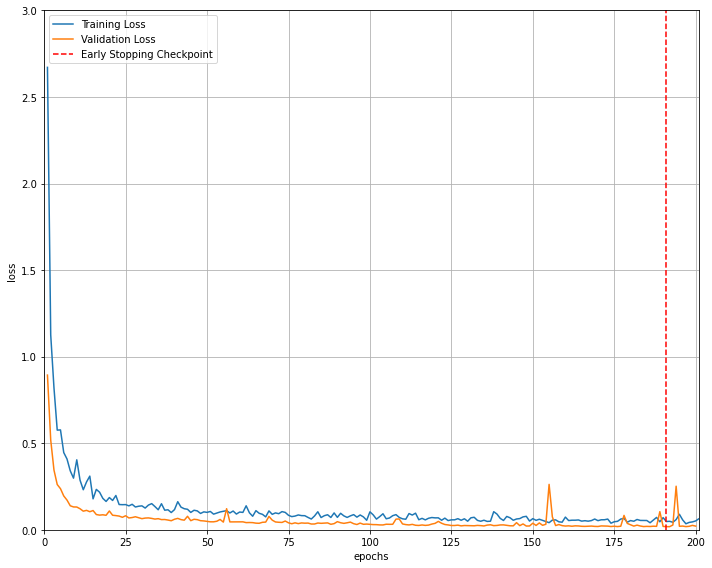

In [15]:
# visualize the loss as the network trained
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = val_losses.index(min(val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 3) # consistent scale
plt.xlim(0, len(val_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Accuracy on test data

In [18]:
test_loss = test(last_model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test set: Average loss: 0.0181, Precision: 0.9224, Recall: 0.8980, F1 score: 0.9052,   Accuracy: 8975/9337 (96%)



Visualizing via Confusion Matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(13.5, -0.5)

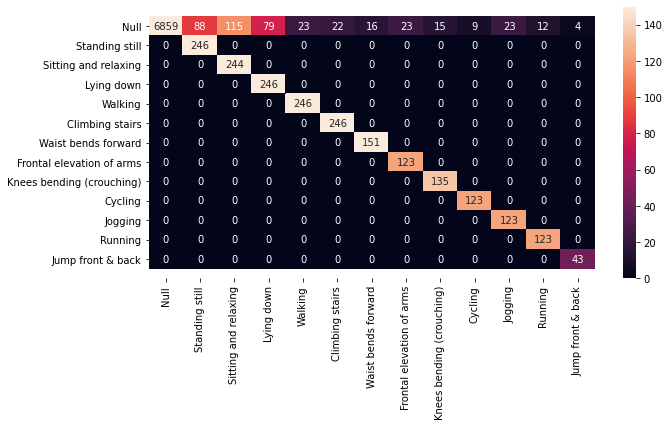

In [17]:
nb_classes = 13

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.float()
        classes = classes.float()
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1



import pandas as pd
import seaborn as sn
array=np.array(confusion_matrix)

gestures=["Null", "Standing still", "Sitting and relaxing", "Lying down", "Walking", "Climbing stairs", "Waist bends forward", "Frontal elevation of arms", "Knees bending (crouching)", "Cycling", "Jogging", "Running", "Jump front & back"]

df_cm = pd.DataFrame(array, index = [i for i in gestures],
                  columns = [i for i in gestures])
# display(df_cm)
plt.figure(figsize = (10, 5))
ax = sn.heatmap(df_cm, vmin=0, vmax=150, annot=True, fmt=".0f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [0]:
for ii in last_model.parameters():
    print(ii.shape)

torch.Size([256, 1, 6, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 6, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 5120])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([13, 128])
torch.Size([13])
